#Лабораторная работа 4

###Выполнили: Аросланкин Артем, Смольникова Полина 

###17ПМИ

# Text generation with deep learning

In [ ]:
import sys

import os
import os.path
import random
import collections
import shutil
import time
import glob
import csv
import re
import gc
import time
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from math import pi
import scipy
import string
import random
import math

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset
from torch.autograd import Variable

import torchvision
from torchvision import transforms, datasets
from torchsummary import summary

from tqdm import tqdm
%matplotlib inline

from bokeh.io import show,output_notebook

output_notebook()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**Задача**

   Обучить character recurrent neural network (char RNN) на датасете статей arxiv, а также на своих данных и исследовать её свойства.

##Датасет

Посмотрим на данные:

In [ ]:
text = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/nlp_lab4/arxiv.csv')['summary']
text

0        In summary of the research findings presented ...
1        In this paper, structural controllability of a...
2        We present a Deep Cuboid Detector which takes ...
3        In this paper, we study the trade-off between ...
4        In this paper, we propose a characterization o...
                               ...                        
27183    Being motivated by the multilayer RECOS (REcti...
27184    Understanding tie strength in social networks,...
27185    We present pyroomacoustics, a software package...
27186    Joint image filters leverage the guidance imag...
27187    Sentiment analysis aims to uncover emotions co...
Name: summary, Length: 27188, dtype: object

Всего в наборе данных 27188 примеров summary.

Было принято решение не убирать все знаки препинания и оставить топ-10 наиболее часто встречающихся (так как текст без знаков препинания выглядит совсем грустно)

##Получение данных из датасета

In [ ]:
class TextDataset(Dataset):
    def __init__(self, file_name, root_dir, file_type, chunk_len=200, batch_size=50):
        if file_type == 'csv':
            self.dataset = pd.read_csv(root_dir + file_name)['summary']
        if file_type == 'txt':
            with open(root_dir + file_name) as f:
                self.dataset = f.read()
        
        self.chunk_len = chunk_len
        self.batch_size = batch_size
        tmp_text = ''.join([data.lower().replace('\n', ' ').replace('\x7f', ' ') for data in self.dataset])
        self.text = self.delete_punctuation(tmp_text)
        self.text_len = len(self.text)

        self.vocabulary = list(set(self.text))
        self.vocabulary_len = len(self.vocabulary)
        self.vocabulary.sort()

        self.char_to_idx = dict((c, i) for i, c in enumerate(self.vocabulary))
        self.idx_to_char = dict((i, c) for i, c in enumerate(self.vocabulary))

    def build_sequence(self):
        input = torch.LongTensor(self.batch_size, self.chunk_len)
        target = torch.LongTensor(self.batch_size, self.chunk_len)
        for bi in range(self.batch_size):
            start_index = random.randint(0, self.text_len - self.chunk_len - 1)
            end_index = start_index + self.chunk_len + 1
            chunk = self.text[start_index:end_index]
            input[bi] = self.char_tensor(chunk[:-1])
            target[bi] = self.char_tensor(chunk[1:])

        input = Variable(input)
        target = Variable(target)
        if cuda:
            input = input.cuda()
            target = target.cuda()
        return input, target

    def delete_punctuation(self, text):
        punctuation_dict = {}
        tokens = text.split()
        for word in tokens:
            if word in string.punctuation: 
                if word not in punctuation_dict:
                    punctuation_dict[word] = 1
                else:
                    punctuation_dict[word] += 1
        top_punctuation = min(10, len(punctuation_dict))

        for i in range(0, top_punctuation):
            max_key = max(punctuation_dict, key=punctuation_dict.get)
            punctuation_dict.pop(max_key)
        if len(punctuation_dict) > 0:
            punctuation_set = ''.join([key for key in punctuation_dict])
            regex_punct = re.compile('[%s]' % re.escape(punctuation_set))
            text = regex_punct.sub('', text)
        return text

    def char_tensor(self, string):
        tensor = torch.zeros(len(string)).long()
        for c in range(len(string)):
            try:
                tensor[c] = self.char_to_idx[string[c]]
            except:
                continue
        return tensor

##Архитектура сети

In [ ]:
class CharRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, model="gru", n_layers=1):
        super(CharRNN, self).__init__()
        self.model = model.lower()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.n_layers = n_layers

        self.encoder = nn.Embedding(input_size, hidden_size)
        if self.model == "gru":
            self.rnn = nn.GRU(hidden_size, hidden_size, n_layers)
        elif self.model == "lstm":
            self.rnn = nn.LSTM(hidden_size, hidden_size, n_layers)
        self.decoder = nn.Linear(hidden_size, output_size)

    def forward(self, input, hidden):
        batch_size = input.size(0)
        encoded = self.encoder(input)
        output, hidden = self.rnn(encoded.view(1, batch_size, -1), hidden)
        output = self.decoder(output.view(batch_size, -1))
        return output, hidden

    def forward2(self, input, hidden):
        encoded = self.encoder(input.view(1, -1))
        output, hidden = self.rnn(encoded.view(1, 1, -1), hidden)
        output = self.decoder(output.view(1, -1))
        return output, hidden

    def init_hidden(self, batch_size):
        if self.model == "lstm":
            return (Variable(torch.zeros(self.n_layers, batch_size, self.hidden_size)),
                    Variable(torch.zeros(self.n_layers, batch_size, self.hidden_size)))
        return Variable(torch.zeros(self.n_layers, batch_size, self.hidden_size))

In [ ]:
def time_since(since):
    s = time.time() - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

In [ ]:
class Model():
    def __init__(self, hidden_size, learning_rate, 
                 chunk_len, batch_size, data, 
                 model_type="gru", n_layers=1, cuda=0):
        self.model = CharRNN(
                              data.vocabulary_len,
                              hidden_size,
                              data.vocabulary_len,
                              model=model_type,
                              n_layers=n_layers
                            )
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=learning_rate)
        self.criterion = nn.CrossEntropyLoss()
        self.chunk_len = chunk_len
        self.batch_size = batch_size
        self.data = data
        self.all_losses = []
        self.cuda = cuda
        if cuda:
           self.model.cuda()

    def info():
        print(self.model)

    def start_train(self, n_epochs = 200, print_every = 100):
        start = time.time()
        print("Training for %d epochs..." % n_epochs)
        for epoch in (range(1, n_epochs + 1)):
            input, target = self.data.build_sequence()
            loss = self.train(input, target)
            self.all_losses.append(loss)

            if epoch % print_every == 0:
                print('[%s (%d %d%%) %.4f]' % (time_since(start), epoch, epoch / n_epochs * 100, loss))
                print(self.generate('A', 100), '\n')

    def train(self, inp, target):
        hidden = self.model.init_hidden(self.batch_size)
        if self.cuda:
            hidden = hidden.cuda()
        self.model.zero_grad()
        loss = 0

        for c in range(self.chunk_len):
            output, hidden = self.model(inp[:,c], hidden)
            loss += self.criterion(output.view(self.batch_size, -1), target[:,c])

        loss.backward()
        self.optimizer.step()
        return loss.item() / self.chunk_len
    
    def plot_loss(self, title='Model Loss'):
        plt.plot(self.all_losses)
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.suptitle(title)
        plt.show()

    def generate(self, prime_str='A', predict_len=100, temperature=0.8, cuda=False):
        hidden = self.model.init_hidden(1)
        prime_input = Variable(self.data.char_tensor(prime_str).unsqueeze(0))

        if self.cuda:
            hidden = hidden.cuda()
            prime_input = prime_input.cuda()
        predicted = prime_str

        # Use priming string to "build up" hidden state
        for p in range(len(prime_str) - 1):
            _, hidden = self.model(prime_input[:,p], hidden)
            
        inp = prime_input[:,-1]
        
        for p in range(predict_len):
            output, hidden = self.model(inp, hidden)
            
            # Sample from the network as a multinomial distribution
            output_dist = output.data.view(-1).div(temperature).exp()
            top_i = torch.multinomial(output_dist, 1)[0]

            # Add predicted character to string and use as next input
            predicted_char = self.data.idx_to_char[top_i.item()]
            predicted += predicted_char
            inp = Variable(self.data.char_tensor(predicted_char).unsqueeze(0))
            if self.cuda:
                inp = inp.cuda()

        return predicted
    

##Эксперименты

Эксперименты показали, что тренируется лучше с большим чанком(окошком).
Поэтому фиксируем параметр *chunk_len = 200* 

Мы рассматриваем 2 архитектуры - GRU и LSTM

###GRU model

  0%|          | 0/2000 [00:00<?, ?it/s]

Training for 2000 epochs...


  5%|▌         | 100/2000 [01:14<24:00,  1.32it/s]

 14s (100 5%) 1.5785]
Aentoring that to and sustas the bajerd tive of the paratomding motions. the ruct cature in a the mes 



 10%|█         | 200/2000 [02:28<22:32,  1.33it/s]

 28s (200 10%) 1.3642]
Aor discovery the performance the been for has with the linear multi-one-of-the-addimity first be fir 



 15%|█▌        | 300/2000 [03:42<21:04,  1.34it/s]

 42s (300 15%) 1.2945]
Aand or improvement possible integration is social with images policitic algorithms of the structure  



 20%|██        | 400/2000 [04:55<19:43,  1.35it/s]

 55s (400 20%) 1.2552]
Athe some in the source of higher tasks and decoveral forma and tools are abe continuous optimization 



 25%|██▌       | 500/2000 [06:08<18:24,  1.36it/s]

 8s (500 25%) 1.2242]
Aprocess of this study architecture is to binal results are depth use over the input improve initial  



 30%|███       | 600/2000 [07:22<17:19,  1.35it/s]

 22s (600 30%) 1.2487]
Aa classification anshome. the corpus with noisy is indicate to analysis and some trajectories with h 



 35%|███▌      | 700/2000 [08:35<16:17,  1.33it/s]

 35s (700 35%) 1.2459]
Arecently scale experimental repla better is can be semantic integrate the utilize of the important i 



 40%|████      | 800/2000 [09:48<15:05,  1.33it/s]

 48s (800 40%) 1.2062]
Aassumption function in solvers neuch was contribution of relations as it has a listapline separal ob 



 45%|████▌     | 900/2000 [11:02<13:45,  1.33it/s]

 2s (900 45%) 1.2034]
Adesign of words content. we also the fields between anlation image extension from uncertainty and sp 



 50%|█████     | 1000/2000 [12:15<12:22,  1.35it/s]

 15s (1000 50%) 1.2017]
Aand security-frame complexities of a static strategies algorithms to selection tasks considered a gr 



 55%|█████▌    | 1100/2000 [13:28<10:56,  1.37it/s]

 28s (1100 55%) 1.2060]
Adensible vertex layer connected by unique accurate the presented point as reduce the  space unreterm 



 60%|██████    | 1200/2000 [14:40<09:56,  1.34it/s]

 40s (1200 60%) 1.1823]
Aproblem is a classifier we study the other tackle the research are resistorizing presented character 



 65%|██████▌   | 1300/2000 [15:53<08:44,  1.34it/s]

 53s (1300 65%) 1.1894]
Abased on overthrings recent are multi-sources of streaming modeled control characterization the spac 



 70%|███████   | 1400/2000 [17:06<07:23,  1.35it/s]

 6s (1400 70%) 1.1984]
Awith process and word results are end-neural closes viewpisal efficiency in two objectively expressi 



 75%|███████▌  | 1500/2000 [18:18<06:08,  1.36it/s]

 18s (1500 75%) 1.2197]
Athe constraint-of-coding simulation employed extracting with the various change learning ratio is kn 



 80%|████████  | 1600/2000 [19:31<04:54,  1.36it/s]

 31s (1600 80%) 1.1720]
Aand empirical spargue the offers consistential achieves in the fine providency text to controllers t 



 85%|████████▌ | 1700/2000 [20:44<03:42,  1.35it/s]

 44s (1700 85%) 1.1959]
Aevents of counter benefically distributed network setting and the exone using the time on the exampl 



 90%|█████████ | 1800/2000 [21:56<02:28,  1.35it/s]

 56s (1800 90%) 1.1740]
Avisual methods and human move the decomposal studies significant program on the first pointing on th 



 95%|█████████▌| 1900/2000 [23:09<01:14,  1.35it/s]

 9s (1900 95%) 1.1832]
Acontroller coefficiently policies which computer to be the time from a time strategy a rate-based al 



100%|██████████| 2000/2000 [24:21<00:00,  1.37it/s]

 21s (2000 100%) 1.1923]
Atree and representation lattically in the proposed or and us is not properties of a conditions learn 



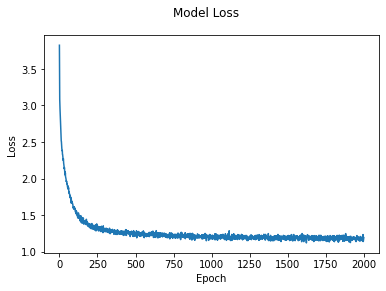

In [ ]:
model_type = "gru"
n_epochs = 2000
print_every = 100
hidden_size = 100
n_layers = 2
learning_rate = 0.01
chunk_len = 200
batch_size = 100
cuda = 0
data = TextDataset('arxiv.csv', '/content/drive/MyDrive/Colab Notebooks/nlp_lab4/', 'csv', chunk_len, batch_size)
gru_model = Model(hidden_size, learning_rate, chunk_len, 
                  batch_size, data, model_type, n_layers, cuda)
gru_model.start_train(n_epochs, print_every)
gru_model.plot_loss()

Примеры генерации gru model с разными температурами:

In [ ]:
for temperature in np.arange(0.2, 1, 0.1):
    print('temperature = %.1f' % temperature, ' ', gru_model.generate('The system is robust ', 100, temperature=temperature))

temperature = 0.2   The system is robust to the state-of-the-art state-of-the-art construction of the state and the structure that in the sta
temperature = 0.3   The system is robust structure the results of results of the survey the state-of-the-art of the method of the states of t
temperature = 0.4   The system is robust to reconstruction and linear of the results for the all transformations and distribution and the int
temperature = 0.5   The system is robust the experiments of a source discrete in particular we can be consider state-of-the-art transformatio
temperature = 0.6   The system is robust to construction problem complexity of a transformation that of solutions including model to the stat
temperature = 0.7   The system is robust communicating copased beniches visual equivalent specifically the analysis of secret convergence sim
temperature = 0.8   The system is robust computer at the strext experimental patterns between soliding to another results are new first the e
temper

Чем выше температура, тем разнообразнее набор слов. Но при этом чаще встречаются ошибки в словах

###LSTM model

  0%|          | 0/2000 [00:00<?, ?it/s]

Training for 2000 epochs...


  5%|▌         | 100/2000 [01:26<28:19,  1.12it/s]

 26s (100 5%) 1.8291]
Aespen by besated the of and. we ablaties to palimites ondew application in canto firvern we not or t 



 10%|█         | 200/2000 [02:53<26:03,  1.15it/s]

 53s (200 10%) 1.5176]
Aof dmodts a network the new algoriby mobution call that of be performarized consistent as audlows op 



 15%|█▌        | 300/2000 [04:19<24:37,  1.15it/s]

 19s (300 15%) 1.3621]
Afake unputs the space. only conceptation and the proposed on subbly for a continuous computation the 



 20%|██        | 400/2000 [05:46<23:39,  1.13it/s]

 46s (400 20%) 1.3358]
Aalgorithm on system of setwares requirements and for the present the proposed or the generalized wit 



 25%|██▌       | 500/2000 [07:12<21:53,  1.14it/s]

 12s (500 25%) 1.2847]
Alearning for this approach and analysis of the vision of each complet operative on the propose a mod 



 30%|███       | 600/2000 [08:37<20:10,  1.16it/s]

 37s (600 30%) 1.2621]
Athe about the end-finding the consists of recovering assuming scale algorithm fapating estimate the  



 35%|███▌      | 700/2000 [10:03<18:39,  1.16it/s]

 2s (700 35%) 1.2466]
Amultiple visual framework an encoder-way the features can to estimated lassuations and has computer  



 40%|████      | 800/2000 [11:28<17:26,  1.15it/s]

 28s (800 40%) 1.2339]
Aa games. introduce that a descent the not polynomisis accurate the finite representations of the con 



 45%|████▌     | 900/2000 [12:54<15:51,  1.16it/s]

 54s (900 45%) 1.2473]
Anonstanding fored constructed detect of these at it is spectract has entity also scorce construct fr 



 50%|█████     | 1000/2000 [14:19<14:24,  1.16it/s]

 19s (1000 50%) 1.2399]
Aneural network tepsss are in the resities. the wlight 2016-k> can be times for 700 transitional chou 



 55%|█████▌    | 1100/2000 [15:44<13:15,  1.13it/s]

 44s (1100 55%) 1.2034]
Aallowes into and space for using the confidence exchannel supponering the introduce a sefment image  



 60%|██████    | 1200/2000 [17:09<11:29,  1.16it/s]

 9s (1200 60%) 1.2308]
Athe low-importantly grank benefits can be full is often stage and the strange of individe heary alge 



 65%|██████▌   | 1300/2000 [18:34<10:00,  1.17it/s]

 34s (1300 65%) 1.1749]
Awe propose a new networks. the matro-labels of concepts of our optimal approaches where our learn to 



 70%|███████   | 1400/2000 [19:58<08:36,  1.16it/s]

 58s (1400 70%) 1.1943]
Aframework in the tasks the first problem where the computational highly single set of cloud research 



 75%|███████▌  | 1500/2000 [21:23<07:14,  1.15it/s]

 23s (1500 75%) 1.1837]
Aalgorithms in users in the most fi-nlc. the detection and in the important supprics and loss of the  



 80%|████████  | 1600/2000 [22:48<05:49,  1.15it/s]

 48s (1600 80%) 1.1914]
Acompared where system. we however the compression and at a features in traffic multichanges for a me 



 85%|████████▌ | 1700/2000 [24:13<04:16,  1.17it/s]

 13s (1700 85%) 1.2089]
Acase of representation and features. makes the discrimination in 2007 network exceary one goal four  



 90%|█████████ | 1800/2000 [25:38<02:53,  1.15it/s]

 38s (1800 90%) 1.1813]
Aof the basition at programs which control on the proposed computation and speech often applying the  



 95%|█████████▌| 1900/2000 [27:02<01:24,  1.18it/s]

 2s (1900 95%) 1.1961]
Athey optimize discusticle that they are the alignment of the ratios and of the behaviors in the exte 



100%|██████████| 2000/2000 [28:27<00:00,  1.17it/s]

 27s (2000 100%) 1.1410]
Acan online it also shop service strongly of the developed to experiments a class of model with activ 



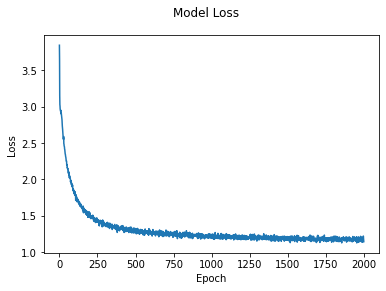

In [ ]:
model_type = "lstm"
n_epochs = 2000
print_every = 100
hidden_size = 100
n_layers = 2
learning_rate = 0.01
chunk_len = 200
batch_size = 100
cuda = 0
data = TextDataset('arxiv.csv', '/content/drive/MyDrive/Colab Notebooks/nlp_lab4/', 'csv', chunk_len, batch_size)
lstm_model = Model(hidden_size, learning_rate, chunk_len, 
                  batch_size, data, model_type, n_layers, cuda)
lstm_model.start_train(n_epochs, print_every)
lstm_model.plot_loss()

In [ ]:
for temperature in np.arange(0.2, 1, 0.1):
    print('temperature = %.1f' % temperature, ' ', lstm_model.generate('The system is robust ', 100, temperature=temperature))

temperature = 0.2   The system is robust to the state-of-the-art constraints and the security and the state-of-the-art control and the contro
temperature = 0.3   The system is robust problems in the state-of-the-art and significant analysis of the decision of the second of the model
temperature = 0.4   The system is robust distributed are not consider the users and performance for the and the solutions with a set of the d
temperature = 0.5   The system is robust to the distribution of the results from this paper strength of model to decision and the article in 
temperature = 0.6   The system is robust to develop the policy of power to previous algorithm content for the realistic problems that related
temperature = 0.7   The system is robust solving change that situation method we call a node in the-art controller and the constraint that ap
temperature = 0.8   The system is robust to speedubleakency representation in in the-ones bounds show that. the randomized parameterization o
temper

Поэкспериментируем с числом слоев на примере LSTM архитектуры. Увеличение количества слоев усложняет модель, соответсвенно время тренировки тоже увеличится

Увеличим количество слоев до 3, остальные параметры без изменений


Training for 2000 epochs...
 11s (100 5%) 2.5489]
Amimicocet monme fas roanse  anget longegchintdin sso ninrenfuren ans tes oto s i-chean ne ticernodet 

 22s (200 10%) 2.0511]
Aange miding in-kan ingentces we a poocets ommisate ant lembulular nitios fard pelecgrt bithen porsix 

 33s (300 15%) 1.7366]
Aos with comparicsided naturition of be vilarificit x gragaeed conplens sefine actric low cmn for a a 

 44s (400 20%) 1.5576]
Aconsel develop base alters of these static obtain moxel bounle the parable gribution and predicties  

 56s (500 25%) 1.4514]
Ain as the dete we bilits are visian more of pair shan when computing the classity only the implicate 

 7s (600 30%) 1.3668]
Aentances of the model agains is case the lerning and pair in the in the wigore for distrifle from se 

 18s (700 35%) 1.3562]
Aa setting tasks it wesology based models we propose classification and parameter in the present codi 

 28s (800 40%) 1.3062]
Aparson to the approach to lineering the proposed for scenario

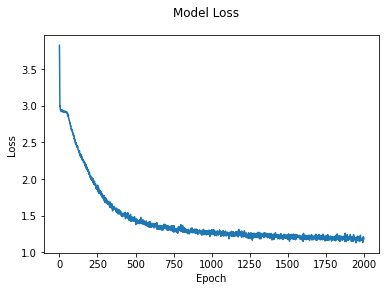

In [ ]:
model_type = "lstm"
n_epochs = 2000
print_every = 100
hidden_size = 100
n_layers = 3
learning_rate = 0.01
chunk_len = 200
batch_size = 100
cuda = 0
data = TextDataset('arxiv.csv', '/content/drive/MyDrive/Colab Notebooks/nlp_lab4/', 'csv', chunk_len, batch_size)
lstm_model = Model(hidden_size, learning_rate, chunk_len, 
                  batch_size, data, model_type, n_layers, cuda)
lstm_model.start_train(n_epochs, print_every)
lstm_model.plot_loss()

In [ ]:
for temperature in np.arange(0.2, 1.5, 0.1):
    print('temperature = %.1f' % temperature, ' ', lstm_model.generate('The system is robust ', 100, temperature=temperature))

temperature = 0.2   The system is robust to design the semantic internet of the proposed network and the state of the proposed proposed metho
temperature = 0.3   The system is robust the approach to address the proposed control polynomial simulation and the proposed approach to addi
temperature = 0.4   The system is robust and computes a subset of the first proposed to consider the result of the algorithm of our strength 
temperature = 0.5   The system is robust a previous proposed proposed should be which for a complex framework to strong and the group that th
temperature = 0.6   The system is robust clusters on an easily used to services and improves implemented to learn of a learning half states s
temperature = 0.7   The system is robust performance using performance and the conclusion for shape for a features we propose a version while
temperature = 0.8   The system is robust approach is consider a binary popular method of do pirearpwe propose to the proposed round different
temper

**Проведем эксперименты с разным значением параметра hidden_size для GRU и LSTM архитектур**

Количество эпох уменьшим до 1000 : *n_epochs = 1000*

Зафиксируем количество слоев *n_layers = 2*, так как изменение в количество слоев не улучшило качество генерации текста

Параметры *chunk_len = 200* и *batch_size = 100*, полученные в прошлых экспериментах, также оставляем без изменений



Model type = lstm , hidden_size = 128
Training for 1000 epochs...
 21s (1000 100%) 1.1672]
Abeand in the discrete also musticate the images we show that these that close state-of-the-art plann 



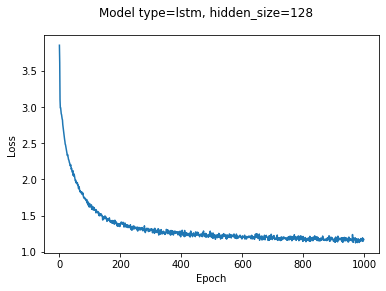

Model type = lstm , hidden_size = 256
Training for 1000 epochs...
 53s (1000 100%) 1.1744]
Adata. the resulting to the applications. the uncertainty been predicted to leverages for learning da 



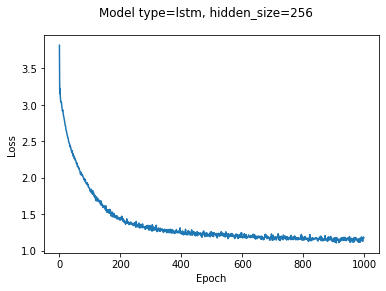

Model type = gru , hidden_size = 128
Training for 1000 epochs...
 22s (1000 100%) 1.1574]
Aa proposed and advantalization. for the algorithm to be used in the two applications while the more  



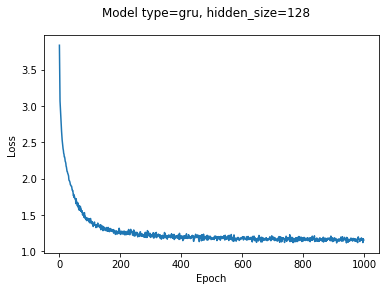

Model type = gru , hidden_size = 256
Training for 1000 epochs...
 36s (1000 100%) 1.1983]
Afor optimized general estimation sparse neural network and related for out of hold not search. the l 



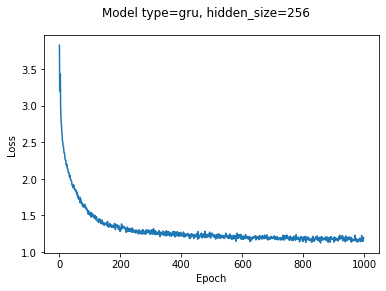

In [ ]:
model_types = ["lstm", "gru"]
hidden_sizes = [128, 256]

n_epochs = 1000
print_every = 1000
n_layers = 2
learning_rate = 0.01
chunk_len = 200
batch_size = 100
cuda = 0
data = TextDataset('arxiv.csv', '/content/drive/MyDrive/Colab Notebooks/nlp_lab4/', 'csv', chunk_len, batch_size)

for model_type in model_types:
    for hidden_size in hidden_sizes:
        print('Model type =', model_type, ', hidden_size =', hidden_size)
        model = Model(hidden_size, learning_rate, chunk_len, 
                          batch_size, data, model_type, n_layers, cuda)
        model.start_train(n_epochs, print_every)
        model.plot_loss('Model type=' + str(model_type) + ', hidden_size=' + str(hidden_size))


## Результаты тренировки

Натренируем финальную модель со следующими параметрами:

Training for 2000 epochs...
 44s (100 5%) 1.4568]
Awaxk their results of the glop assem with a mechay such soch difference untergenessly ching conseval 

 28s (200 10%) 1.2933]
Aa visual control forward generate amounts to a language of true difficiency general multiple and exi 

 11s (300 15%) 1.2315]
Ahyparse testing descrive the rank information we show roup behind the method in interaction solution 

 55s (400 20%) 1.2256]
Ascorest authentic at the environment that has been prival sensities and the categories since communi 

 38s (500 25%) 1.1747]
Aakent the minory in a framework sease of network global for re-dimension of identities individual co 

 21s (600 30%) 1.1825]
Akey separation in the fith in this paper is a previous transformation map of our models we primes we 

 4s (700 35%) 1.1959]
A1 of the training an information using a data the observation of the reduced that the mechanism over 

 47s (800 40%) 1.1919]
Aa computation into the framework relay away and interpretable

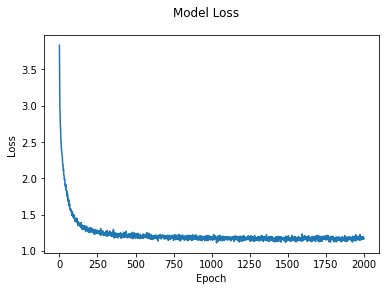

In [ ]:
model_type = "gru"
n_epochs = 2000
print_every = 100
hidden_size = 128
n_layers = 2
learning_rate = 0.01
chunk_len = 200
batch_size = 100
cuda = 0
data = TextDataset('arxiv.csv', '/content/drive/MyDrive/Colab Notebooks/nlp_lab4/', 'csv', chunk_len, batch_size)
final_model = Model(hidden_size, learning_rate, chunk_len, 
                  batch_size, data, model_type, n_layers, cuda)
final_model.start_train(n_epochs, print_every)
final_model.plot_loss()

In [ ]:
final_model.generate('To summarize ', 300, temperature=0.7)

'To summarize the uniform that it long-showed the structure of short af new algorithms that are to repositories of the qualitation our approach to influence to survey the first channel approaches this problem of any learning approach to obtain this algorithm is adeference of the intermining a delta-compared to th'

# Работа с собственным датасетом

В качестве русскоязычного датасета для генерации текстов были выбраны тексты группы "Кровосток"

Повторим тот же pipeline

Model type = lstm , hidden_size = 128
Training for 1000 epochs...
 12s (1000 100%) 0.2399]
Aпод второго не до закуршить грабить слова однополово, всегда что так же помнятия и дальше падал голи 



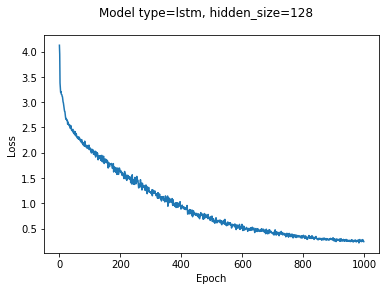

Model type = lstm , hidden_size = 256
Training for 1000 epochs...
 40s (1000 100%) 0.1815]
Aсебя, это в пизду но кто острой теме. я делаю свой пых-пых святые на стволах бросил гранату разбрызг 



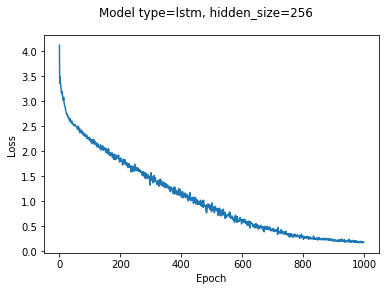

Model type = gru , hidden_size = 128
Training for 1000 epochs...
 43s (1000 100%) 0.7025]
Aслой. позорыды, бок любую питаться, и похуемправов и пока долбил у предсталось препаласный и гаши, н 



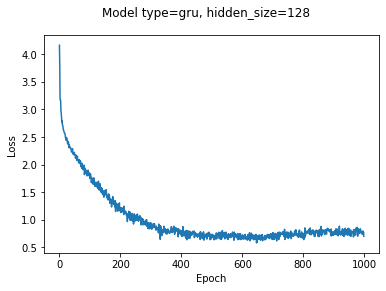

Model type = gru , hidden_size = 256
Training for 1000 epochs...
 25s (1000 100%) 0.4015]
Aдетпевается, я светлые всё наполовину полон, на пох у волгу я пох ты не смогу я видец, ты это в этом 



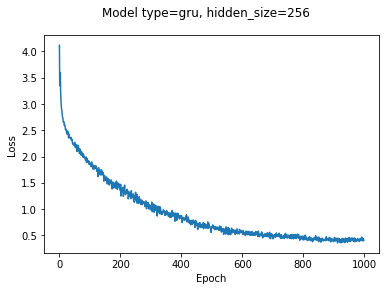

In [ ]:
model_types = ["lstm", "gru"]
hidden_sizes = [128, 256]

n_epochs = 1000
print_every = 1000
n_layers = 2
learning_rate = 0.01
chunk_len = 200
batch_size = 30
cuda = 0
data = TextDataset('krovostok.txt', '/content/drive/MyDrive/Colab Notebooks/nlp_lab4/', 'txt', chunk_len, batch_size)

for model_type in model_types:
    for hidden_size in hidden_sizes:
        print('Model type =', model_type, ', hidden_size =', hidden_size)
        krovostok_model = Model(hidden_size, learning_rate, chunk_len, 
                          batch_size, data, model_type, n_layers, cuda)
        krovostok_model.start_train(n_epochs, print_every)
        krovostok_model.plot_loss('Model type=' + str(model_type) + ', hidden_size=' + str(hidden_size))

###Итоговая модель

Training for 1200 epochs...
 12s (100 8%) 2.3826]
Aпохульны мить не мовак в дуда серить в вна басто и дораснить кость нен тельтру, бронит отче от че пр 

 25s (200 16%) 2.0135]
Aя помнет страли у с всебул как в житьки сы у с из это больбо полосвовся а влязвет хуй, ду отколся та 

 36s (300 25%) 1.6766]
Aвепесийские сами манипомо, был отрики так на жить плохой тромой задных затолько вот дожет тука на за 

 48s (400 33%) 1.3761]
Aприоткрытных у него не приручают хуй потом что леху нет твой умелчит говорит, ради, клен когда захар 

 59s (500 41%) 1.0589]
Aпристелась ковратся в как хуйне, оказалась мы любители из всех муска, мне пиздатает ты ранености соп 

 10s (600 50%) 0.8553]
A— мубить лохи косно, хлебных портивно так постелем понюхаю, будто большой свой смотром не звук вытир 

 21s (700 58%) 0.5901]
Aнас осталось опер сделал с правильных каше, «тых деревни чем ты ближе к земле, тем ближе к тебе черв 

 33s (800 66%) 0.4740]
Aзабыли ебучие глазами рэпак огромные сопронная сеть его не п

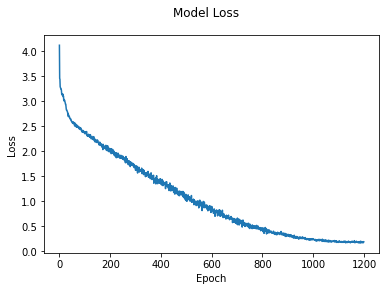

In [ ]:
model_type = "lstm"
hidden_size = 256
n_epochs = 1200
print_every = 100
n_layers = 2
learning_rate = 0.01
chunk_len = 200
batch_size = 30
cuda = 0
data = TextDataset('krovostok.txt', '/content/drive/MyDrive/Colab Notebooks/nlp_lab4/', 'txt', chunk_len, batch_size)
krovostok_model = Model(hidden_size, learning_rate, chunk_len, 
                  batch_size, data, model_type, n_layers, cuda)
krovostok_model.start_train(n_epochs, print_every)
krovostok_model.plot_loss()

In [ ]:
for temperature in np.arange(0.3, 2, 0.3):
    print('temperature = %.1f' % temperature, ' ', krovostok_model.generate('Россия ', 100, temperature=temperature))

temperature = 0.3   Россия так поддержите, сделав напас кому важен шершавый инструментал на нем теплый вокал ложащийся как масл
temperature = 0.6   Россия радость наполнила рот, вот и всё приплыли раздевайся иди в душ помой пизду обнови потёкшую тушь гово
temperature = 0.9   Россия так поддержите, сделав напас кому вас щенок телефона я собой в гроба ее вампиры я жизнь у меня салфе
temperature = 1.2   Россия там в тувидьки деньги а жопы в будущем не отпускаю них сам чё говорит темы стрелы в мозг переносится
temperature = 1.5   Россия так просили я предохранителя вспомнился свинос ее гда все еще я... стоанны как то мильный, лих дету,
temperature = 1.8   Россия еклен, юсь в горячих девецсят как пузырь, вспомнил кто что бы нариков тащи, похуя по вкущу вщищийся 


In [ ]:
krovostok_model.generate('Россия ', 300, temperature=0.9)

'Россия так поддержите, сделано зал, переобуться в тапки и в который раз потерялся в под присмотром чуткого бога повторяй эту поебень чаще, повторяй, даже если звучит убого тебе не бульоне показали колоть ещё хромает подходим к машинам макаровых смотрела в мою сторону я вмяике ты пылесосишь под диваном или '

##Выводы

Лучшие результаты продемонстрировала модель с архитектурой LSTM, *hidden size=256*, *chunk=200*, *num_layers=2*. 

Стоит отметить, что она лучшая несмотря на смену датасетов, и языка. Однако, у архитектуры GRU есть преимущество, она быстрее тренируется. Что при реальном использовании архитектуры может дать выбор в ее пользу.

По поводу инференса - оптимальная температура 0.6-0.9.

Сгенерированный текст с оптимальным набором параметров - почти похож на реальный текст любой песни кровостока: "Россия радость наполнила рот, вот и всё приплыли. Раздевайся иди в душ помой пизду обнови потёкшую тушь гово....". 

